Подключение библиотек

In [34]:
!pip install -U keras-tuner
!pip install -U pygal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import boston_housing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from keras.regularizers import L1, L2
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)
Requirement already up-to-date: pygal in /usr/local/lib/python3.6/dist-packages (2.4.0)


Подключение набора данных

In [35]:
df = pd.read_csv("/content/drive/My Drive/Лаб1/train.csv")
df

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,06/25/2008,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5787594.0
133,133,10/12/2006,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,9262754.0
134,134,07/08/2006,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2544857.0
135,135,10/29/2010,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,7217634.0


Получение целевых ответов

In [36]:
target = df.get('revenue')

df.drop('revenue', axis='columns', inplace=True)
df.drop('Id', axis='columns', inplace=True)

target = np.array(target)
target

array([ 5653753.,  6923131.,  2055379.,  2675511.,  4316715.,  5017319.,
        5166635.,  4491607.,  4952497.,  5444227.,  3745135.,  5161370.,
        1734634.,  4807746.,  1999097.,  3218918., 19696939.,  8213524.,
        5337526.,  2021934.,  5525735.,  1149870.,  3956086.,  2999068.,
        8904084.,  3778621.,  2267425.,  5435276.,  4705945.,  3447890.,
        3008199.,  2058644.,  3261924.,  2371202.,  4100886.,  3903884.,
        3028267.,  2740687.,  5461700.,  3818055.,  6836483.,  4554237.,
        4952255.,  2732645.,  4264176.,  3752885.,  4250758.,  7865428.,
        7201784.,  8630682.,  2156098.,  3273041.,  1763231.,  5595267.,
        4651866.,  6941173.,  2390534.,  3258837.,  3004429.,  3600467.,
        3164972.,  4350573.,  5286212.,  1619683.,  2551252.,  1756069.,
        1882131.,  4052733.,  3836721.,  3452382.,  3982767.,  4136425.,
        2525375.,  3347767.,  5500818., 16549064.,  4590423.,  1904842.,
        3871344.,  6313221.,  3727364.,  4066618., 

Список буквенных признаков

In [37]:
letter_signs = [var for var in df.columns if df[var].dtypes == 'O']
df[letter_signs]

,Open Date,City,City Group,Type
0,07/17/1999,İstanbul,Big Cities,IL
1,02/14/2008,Ankara,Big Cities,FC
2,03/09/2013,Diyarbakır,Other,IL
3,02/02/2012,Tokat,Other,IL
4,05/09/2009,Gaziantep,Other,IL
...,...,...,...,...
132,06/25/2008,Trabzon,Other,FC
133,10/12/2006,İzmir,Big Cities,FC
134,07/08/2006,Kayseri,Other,FC
135,10/29/2010,İstanbul,Big Cities,FC


Перевод буквенных признаков в числовые

In [38]:
df = pd.DataFrame(df[letter_signs])
df[letter_signs] = df.apply(preprocessing.LabelEncoder().fit_transform)

df[letter_signs]
df

,Open Date,City,City Group,Type
0,59,31,0,2
1,16,3,0,1
2,20,10,1,2
3,10,28,1,2
4,41,14,1,2
...,...,...,...,...
132,53,29,1,1
133,94,32,0,1
134,55,18,1,1
135,103,31,0,1


Нормализация данных

In [39]:
def normalize(df):
  # Среднее значение
  mean = df.mean(axis=0)
  # Стандартное отклонение
  std = df.std(axis=0)
  df -= mean
  df /= std
  return df

df = normalize(df)
df

,Open Date,City,City Group,Type
0,-0.158924,0.877538,-0.866539,1.11294
1,-1.252643,-1.491383,-0.866539,-0.84184
2,-1.150901,-0.899152,1.145593,1.11294
3,-1.405254,0.623725,1.145593,1.11294
4,-0.616760,-0.560735,1.145593,1.11294
...,...,...,...,...
132,-0.311536,0.708330,1.145593,-0.84184
133,0.731312,0.962142,-0.866539,-0.84184
134,-0.260666,-0.222318,1.145593,-0.84184
135,0.960229,0.877538,-0.866539,-0.84184


Разделение на тренировочные и тестовые данные

In [40]:
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=2)

Создание и тренировка сети

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 4096)              20480     
_________________________________________________________________
dropout_18 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 1025      
Total params: 4,216,833
Trainable params: 4,216,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
76/76 [==============================] - 1s 6ms/step - loss: 4747501.3506 - mae: 4747501.3506 - va

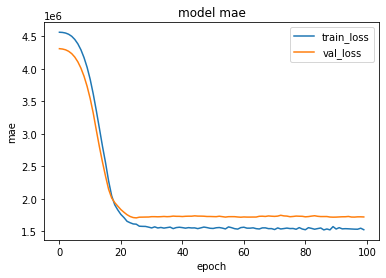

In [41]:
model = Sequential()
model.add(Dense(4096, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history=model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1, validation_split=0.3)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

Предсказание модели

In [42]:
pred = model.predict(x_test)
pred = np.reshape(pred, (pred.shape[0]))
correct = np.reshape(y_test, (y_test.shape[0]))

Подсчет коэффициента корреляции модели

In [43]:
correlation = np.corrcoef(pred, correct)
correlation_coef = correlation[0][1]
print(f'Correlation Coefficient: {correlation_coef}')

! rm -rf untitled_project/

Correlation Coefficient: 0.49851538384060173


Поиск лучшей модели с помощью keras tuner

In [44]:
def build_model(hp):
  hidden_layers = hp.Choice('hidden_layers', values=[1,2,3])
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model = Sequential()
  model.add(Dense(units=hp.Int('units',min_value=16,max_value=256,step=32),activation=activation_choice, input_shape=(x_train.shape[1],)))
  model.add(Dropout(0.2))
  for i in range(hidden_layers):
    model.add(Dense(units=hp.Int(f'layer_{i}_units_',min_value=16//(i+1), max_value=256//(i+1),step=32//(i+1)),activation=activation_choice))
    model.add(Dropout(0.2))
  model.add(Dense(1))  
  model.compile(optimizer='rmsprop', loss="mae", metrics=["mae"])
  return model

def find_best_NN(x_train_main, y_train_main):
  tuner = Hyperband(build_model, objective="loss", max_epochs=10, hyperband_iterations=10)
  tuner.search(x_train, y_train, batch_size=1, epochs=10, validation_split=0.3)
  tuner.results_summary()
  print("\n\n\n")
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model
  

best_model = find_best_NN(x_train, y_train)

Trial 300 Complete [00h 00m 03s]
loss: 4538783.0

Best loss So Far: 2771566.75
Total elapsed time: 00h 09m 17s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
hidden_layers: 3
activation: relu
units: 208
layer_0_units_: 208
layer_1_units_: 40
layer_2_units_: 55
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 2771566.75
Trial summary
Hyperparameters:
hidden_layers: 3
activation: selu
units: 112
layer_0_units_: 240
layer_1_units_: 88
layer_2_units_: 65
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 3514063.25
Trial summary
Hyperparameters:
hidden_layers: 3
activation: elu
units: 240
layer_0_units_: 48
layer_1_units_: 88
layer_2_units_: 75
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 3540042.0
Trial summary
Hyperparameters:
hidden_layers: 3
activation: selu
units: 8

Обучение лучшей модели

Epoch 1/250
87/87 [==============================] - 0s 4ms/step - loss: 1420153.8750 - mae: 1420153.8750 - val_loss: 1911493.5000 - val_mae: 1911493.5000
Epoch 2/250
87/87 [==============================] - 0s 3ms/step - loss: 1419994.8750 - mae: 1419994.8750 - val_loss: 1915054.5000 - val_mae: 1915054.5000
Epoch 3/250
87/87 [==============================] - 0s 3ms/step - loss: 1447799.7500 - mae: 1447799.7500 - val_loss: 1917528.7500 - val_mae: 1917528.7500
Epoch 4/250
87/87 [==============================] - 0s 3ms/step - loss: 1433827.0000 - mae: 1433827.0000 - val_loss: 1917082.1250 - val_mae: 1917082.1250
Epoch 5/250
87/87 [==============================] - 0s 3ms/step - loss: 1438685.3750 - mae: 1438685.3750 - val_loss: 1916617.1250 - val_mae: 1916617.1250
Epoch 6/250
87/87 [==============================] - 0s 3ms/step - loss: 1521718.8750 - mae: 1521718.8750 - val_loss: 1924796.5000 - val_mae: 1924796.5000
Epoch 7/250
87/87 [==============================] - 0s 3ms/step - los

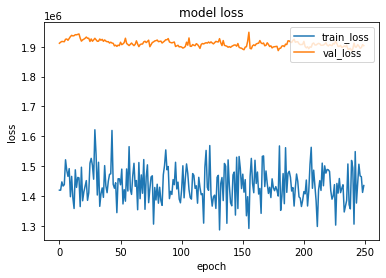

In [46]:
best_history = best_model.fit(x_train, y_train, epochs=250, batch_size=1, validation_split=0.2)

plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

pred = best_model.predict(x_test)
pred = np.reshape(pred, (pred.shape[0]))
correct = np.reshape(y_test, (y_test.shape[0]))

Подсчет коэффициента корреляции лучшей модели

In [47]:
correlation = np.corrcoef(pred, correct)
correlation_coef = correlation[0][1]
print(f'Correlation Coefficient: {correlation_coef}')

Correlation Coefficient: 0.23972255533363138
